### Run the cell below to get familiarized with classes in python which is required for the assignment
#### You can skip this if you're already comfortable with classes

In [4]:
# Run this cell to get familiarized with how classes work in python
# A 'Class' is like a blueprint. An 'Object' is the actual thing you build from that blueprint.

class Hero:
    # The __init__ method is the 'Constructor'.
    # It sets up the initial stats for every new object (a hero in this case) you create.
    # 'self' refers to the specific object (hero) we are talking to right now.
    def __init__(self, name, health):
        self.name = name          # Attribute: A string to store the name
        self.hp = health          # Attribute: An integer for health points
        self.inventory = []       # Attribute: A list that starts empty for every hero
        self.is_alive = True      # Attribute: A boolean to track status
        
        print(f"-> Created {self.name} with {self.hp} HP.")

    # This is a 'Method'. It's a function that only this class can use.
    # Notice 'self' must be the first argument so the hero can access its own HP.
    def take_damage(self, amount):
        self.hp -= amount
        print(f" ! {self.name} took {amount} damage. Current HP: {self.hp}")
        
        if self.hp <= 0:
            self.is_alive = False
            print(f" x {self.name} has died.")

    # Another method that updates the hero's internal list
    def find_item(self, item):
        self.inventory.append(item)
        print(f" + {self.name} found a {item}!")

# --- HOW TO USE THE CLASS ---

# 1. We create an 'Instance' (the object) by calling the class name.
# This automatically runs the __init__ function.
player = Hero("Arthur", 100)

# 2. We access data inside the object using 'dot notation' (object.variable)
print(f"Starting stats: Name={player.name}, Alive={player.is_alive}")

# 3. We perform actions by calling the methods we defined above.
player.take_damage(25)
player.find_item("Shield")
player.find_item("Health Potion")

# 4. The object 'remembers' its state. Let's look at the inventory we built:
print(f"Final Inventory for {player.name}: {player.inventory}")

# 5. Every object is independent. Creating 'player2' won't affect 'player'!
player2 = Hero("Morgana", 80)
print(f"Is {player.name} still at 100 HP? No, it is {player.hp}")
print(f"Is {player2.name} at 100 HP? No, it is {player2.hp}")

-> Created Arthur with 100 HP.
Starting stats: Name=Arthur, Alive=True
 ! Arthur took 25 damage. Current HP: 75
 + Arthur found a Shield!
 + Arthur found a Health Potion!
Final Inventory for Arthur: ['Shield', 'Health Potion']
-> Created Morgana with 80 HP.
Is Arthur still at 100 HP? No, it is 75
Is Morgana at 100 HP? No, it is 80


# Assignment: Multi-Armed Bandits

In this assignment, you will implement and compare three classic algorithms for the Multi-Armed Bandit (MAB) problem:
1. **epsilon-Greedy Algorithm**
2. **Upper Confidence Bound (UCB) Algorithm**
3. **Thompson Sampling**

You are provided with the environment classes (`Arm` and `MultiBandit`). Your task is to fill in the logic for each algorithm class.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class Arm:
    def __init__(self, p):
        self.p = p
    
    def pull(self):
        return np.random.binomial(1, self.p)

class MultiBandit:
    def __init__(self, probs = [0.1, 0.2, 0.7, 0.5]):
        self.__arms = [Arm(p) for p in probs]
        self.__regret = 0
        self.__maxp = max(probs)

    def num_arms(self):
        return len(self.__arms)

    def pull(self, arm_num):
        reward = self.__arms[arm_num].pull()
        self.__regret += self.__maxp - self.__arms[arm_num].p
        return reward
    
    def regret(self):
        return self.__regret

## 1. epsilon-Greedy Algorithm

In [6]:
class EpsilonGreedyAlgorithm:
    def __init__(self, num_arms, horizon, epsilon):
        self.num_arms = num_arms
        self.horizon = horizon
        self.epsilon = epsilon
        self.arm_pulls = np.zeros(num_arms)
        self.arm_rewards = np.zeros(num_arms)
        self.regrets = np.zeros(horizon)
        # You might want an array to store average rewards

    def give_best_arm(self):
        avg_rewards = self.arm_rewards / self.arm_pulls
        return np.argmax(avg_rewards)
        pass

    def select_arm(self):
        for i in range(self.num_arms):
            if self.arm_pulls[i] == 0:
                return i

        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_arms)
        else:
            return self.give_best_arm()
        pass

    def run_algorithm(self, bandit):
        for t in range(self.horizon):
            arm_to_pull = self.select_arm()
            reward = bandit.pull(arm_to_pull)
            
            self.arm_pulls[arm_to_pull] += 1
            self.arm_rewards[arm_to_pull] += reward
            self.regrets[t] = bandit.regret()
            pass

## 2. Upper Confidence Bound (UCB)

In [7]:
class UCBAlgorithm:
    def __init__(self, num_arms, horizon):
        self.num_arms = num_arms
        self.horizon = horizon
        self.timestep = 0
        self.arm_pulls = np.zeros(num_arms)
        self.arm_rewards = np.zeros(num_arms)
        self.regrets = np.zeros(horizon)

    def select_arm(self):
        for i in range(self.num_arms):
            if self.arm_pulls[i] == 0:
                return i

        ucb_values = ((self.arm_rewards / self.arm_pulls) +np.sqrt(2 * np.log(self.timestep) / self.arm_pulls))
        return np.argmax(ucb_values)
        pass

    def run_algorithm(self, bandit):
        for t in range(self.horizon):
            self.timestep += 1
            arm = self.select_arm()
            reward = bandit.pull(arm)

            self.arm_pulls[arm] += 1
            self.arm_rewards[arm] += reward
            self.regrets[t] = bandit.regret()
            pass

## 3. Thompson Sampling
Implement Thompson Sampling using a Beta Distribution as the prior for each arm's success probability.

In [8]:
class ThompsonSamplingAlgorithm:
    def __init__(self, num_arms, horizon):
        self.num_arms = num_arms
        self.horizon = horizon
        self.successes = np.zeros(num_arms)
        self.failures = np.zeros(num_arms)
        self.regrets = np.zeros(horizon)

    def select_arm(self):
        samples = np.random.beta(self.successes + 1, self.failures + 1 )
        return np.argmax(samples) 

    def run_algorithm(self, bandit):
        for t in range(self.horizon):
            arm_to_pull = self.select_arm()
            reward = bandit.pull(arm_to_pull)
            
            if reward == 1:
                self.successes[arm_to_pull] += 1
            else:
                self.failures[arm_to_pull] += 1

            self.regrets[t] = bandit.regret()
            pass

## 4. Comparison and Visualization
Run all three algorithms on a bandit with probabilities `[0.4, 0.1, 0.6, 0.2]` for 250 timesteps and plot their cumulative regret.

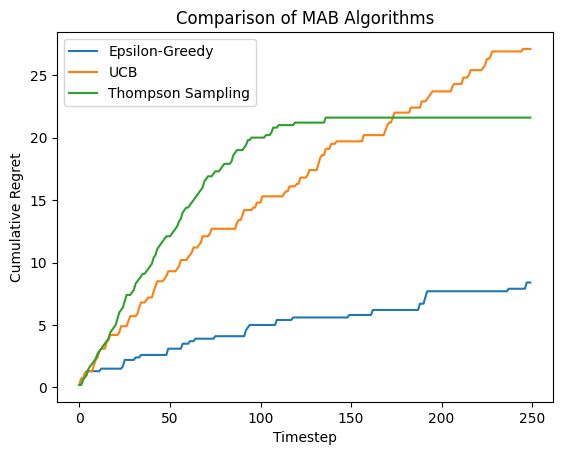

In [9]:
probs = [0.4, 0.1, 0.6, 0.2]
H = 250

bandit1 = MultiBandit(probs)
bandit2 = MultiBandit(probs)
bandit3 = MultiBandit(probs)

eg = EpsilonGreedyAlgorithm(len(probs), H, epsilon=0.1)
ucb = UCBAlgorithm(len(probs), H)
ts = ThompsonSamplingAlgorithm(len(probs), H)

eg.run_algorithm(bandit1)
ucb.run_algorithm(bandit2)
ts.run_algorithm(bandit3)

plt.plot(eg.regrets, label="Epsilon-Greedy")
plt.plot(ucb.regrets, label="UCB")
plt.plot(ts.regrets, label="Thompson Sampling")

plt.xlabel('Timestep')
plt.ylabel('Cumulative Regret')
plt.title('Comparison of MAB Algorithms')
plt.legend()
plt.show()